In [1]:
# jupyter nbconvert HW5.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove-cell"}' --to pdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
%matplotlib inline
%config InlineBackend.figure_format = 'png'

from pylab import rcParams
rcParams.update({"axes.grid" : True})
rcParams['figure.figsize'] = (6,4)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.weight'] = 400
rcParams['font.size'] = 9
rcParams['xtick.color'] = '#111111'
rcParams['ytick.color'] = '#111111'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.titleweight'] = 500
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

# About HW5

We utilize the coordinate descent algorithm introduced in the class to implement the entire Lasso solution. For coordinate descent, you may also want to review HW4. This HW involves two steps: in the first step, we solve the solution for a fixed $\lambda$ value, while in the second step, we consider a sequence of $\lambda$ values and solve it using the path-wise coordinate descent. 

# Question 1 [50 Points] Lasso solution for fixed $\lambda$ 

For this question, you cannot use functions from any additional library, except the `MASS` package, which is used to generate multivariate normal data. Following HW4, we use the this version of the objective function: 

$$\arg\min_{\beta} \frac{1}{n} \lVert \mathbf{y} - \mathbf{X}\beta \rVert^2 + \lambda \lVert \beta \rVert_1$$

The following data is used to fit this model. You can consider using similar functions in Python if needed. We use 

```{r}
  library(MASS)
  set.seed(10)
  n = 100
  p = 200

  # generate data
  V = matrix(0.3, p, p)
  diag(V) = 1
  X_org = as.matrix(mvrnorm(n, mu = rep(0, p), Sigma = V))
  true_b = c(1:3, -3:-1, rep(0, p-6))
  y_org = X_org %*% true_b + rnorm(n)

  # pre-scaling and centering X and y
  X = scale(X_org)*sqrt(n/(n-1))
  y = scale(y_org)*sqrt(n/(n-1))
  lambda = 0.3
  
  write.csv(X,"/Users/harrisnisar/Documents/Stat 542/HW5/data/X.csv", row.names = FALSE)
  write.csv(y,"/Users/harrisnisar/Documents/Stat 542/HW5/data/y.csv", row.names = FALSE)
```

Since we will eventually be comparing our results to what R's glmnet package gives us, I decided to just use the exact data generated in the notebook by saving it to csv (last two lines above) and then reading it as follows:

In [2]:
# TO-DO: implement the data generation in python... I just saved the iimportant stuff in r and loaded here
X_org = np.array(pd.read_csv('./data/X_org.csv'))
y_org = np.array(pd.read_csv('./data/y_org.csv')).reshape(-1)

mean_X = X_org.mean(axis=0)
sd_X = X_org.std(axis=0)

mean_y = y_org.mean()
sd_y = y_org.std()

X = np.array(pd.read_csv('./data/X.csv'))
y = np.array(pd.read_csv('./data/y.csv')).reshape(-1)

a) [10 pts] State the solution $x$ of the following problem
$$
\underset{x}{\arg \min} \,\, (x-b)^{2}+\lambda|x|, \quad \lambda>0
$$
Let's call the function we are trying to minimize $L(x)$:
$$
\underset{x}{\arg \min} \,\, L(x), \quad \lambda>0
$$
Because we have a discontinuity in our function due to the absolute value, we solve the derivate in pieces by looking at regions before ($x>0$) and after ($x<0$) the discontinuity.

When $x>0$:
$$
\frac{\delta L}{\delta x} = 2(x-b)+\lambda = 0\\
x = b - \frac{\lambda}{2}
$$
When $x<0$:
$$
\frac{\delta L}{\delta x} = 2(x-b)-\lambda = 0\\
x = b + \frac{\lambda}{2}
$$

$$x=
\begin{cases}
      b-\frac{\lambda}{2}, & \text{if}\ b>\frac{\lambda}{2} \\
      b+\frac{\lambda}{2}, & \text{if}\ b<-\frac{\lambda}{2} \\
      0, & \text{otherwise}
\end{cases}
$$



Then, implement a function in the form of `soft_th <- function(b, lambda)` to return the result of the above problem. Note in the coordinate descent discussed in the slides, where $b$ is an OLS estimator, and $\lambda$ is the penalty parameter. Report the function output for the following testing cases with $\lambda = 0.3$: 1) $b = 1$; 2) $b = -1$; 3) $b = -0.1$.

In [3]:
def soft_th(b, lam):
    half_lam = lam/2
    if(b > half_lam):
        return b - half_lam
    elif(b < -half_lam):
        return b + half_lam
    else:
        return 0  

In [4]:
lam = 0.3

dict = {
        'b = 1' : [soft_th(1, lam)],
        'b = -1' : [soft_th(-1, lam)],
        'b = -0.1' : [soft_th(-0.1, lam)],
       }

df = pd.DataFrame(dict)
df = df.rename(index={0: 'lambda = 0.3'})
display(df.T)

,lambda = 0.3
b = 1,0.85
b = -1,-0.85
b = -0.1,0.00


b) [40 pts] We will use the pre-scale and centered data `X` and `y` for this question, hence no intercept is needed. Write a Lasso algorithm function `myLasso(X, y, lambda, beta_init, tol, maxitr)`,  which return two outputs (as a list with two components): 
- a vector of $\beta$ values **without** the intercept 
- number of iterations
    
You need to consider the following while completing this question:
- Do not use functions from any additional library
- Start with a vector `beta_init`: $\boldsymbol \beta = \mathbf{0}_{p \times 1}$
- Use the soft-threshold function in the iteration when performing the coordinate-wise update. 
- Use the efficient $\mathbf{r}$ updating appraoch (we discussed this in lecture and HW4) in the iteration
- Run your coordinate descent algorithm for a maximum of `maxitr` = 100 iterations. Each iteration should loop through all variables. 
- You should implement the early stopping rule with `tol`. This means terminating the algorithm when the $\boldsymbol \beta$ value of the current iteration is sufficiently similar to the previous one, i.e., $\lVert \boldsymbol \beta^{(k)} - \boldsymbol \beta^{(k-1)} \rVert^2 \leq \text{tol}$. 

Aftering completing your code, run it on the data we generated previously. Provide the following results: 
- Print out the first 8 coefficients and the number of iterations.
- Check and compare your answer to the `glmnet` package using the following code. You should report their __first 8 coefficients__ and the $L_1$ norm of the difference $\| \, \hat{\boldsymbol\beta}^\text{glment}_{[1:8]} - \hat{\boldsymbol\beta}^\text{yours}_{[1:8]} \, \|_1$. 

```{r}
  library(glmnet)
  # glmnetfit use a different loss function. Use lambda / 2 as the penalty
  glmnetfit = glmnet(X, y, lambda = lambda / 2, intercept = FALSE)
  glmnetfit$beta[1:8]
```

In [5]:
def myLasso(X, y, lam, beta_init, tol, max_iter):
    beta = beta_init

    for k in range(max_iter):
        r = y - X @ beta
        beta_to_set = np.zeros(X.shape[1])
        for j in range(p):
            r = r + X[:,j] * beta[j]
            beta_ols_j = np.mean(r * X[:,j])
            beta_to_set[j] = soft_th(beta_ols_j, lam)
            r = r - X[:,j] * beta_to_set[j]
            
        # tolerance check    
        if(np.linalg.norm((beta - beta_to_set), ord=1) <= tol):
            #print(f'Converged at {k} ({np.linalg.norm((beta - beta_to_set), ord=1)})')
            return beta
        beta = beta_to_set
        
        
    return beta

In [6]:
n = 100
p = 200
betas_lasso = myLasso(X, y, lam, np.zeros(p), 1e-7, 100)
print('First 8 betas:')
print(betas_lasso[0:8])

# I saved the betas from the R file and loaded here:
betas_glmnet = np.array(pd.read_csv('./data/glmnet_betas.csv')).reshape(-1)
first_eight_betas_glmnet = betas_glmnet[0:8] 
L1_norm = np.linalg.norm((first_eight_betas_glmnet - betas_lasso[0:8]), ord=1)
print(f'L1 Norm: {L1_norm}')

First 8 betas:
[ 0.          0.15823488  0.42964715 -0.51944529 -0.17147606 -0.00664524
  0.          0.        ]
L1 Norm: 3.221376238462647e-05


# Question 2 [50 Points] Path-wise Coordinate Descent

Let's perform path-wise coordinate descent. The idea is simple: we will solve the solution on a sequence of $\lambda$ values, starting from the largest one in the sequence. The first initial $\boldsymbol\beta$ are still all zero. After obtaining the optimal $\boldsymbol \beta$ for a given $\lambda$, we simply use this solution as the initial value for the next, smaller $\lambda$. This is referred to as a __warm start__ in optimization problems. We will consider the following sequence of $\lambda$ borrowed from `glmnet`. Note that this is a decreasing sequence from large to small values.

```{r}
  glmnetfit = glmnet(X, y, intercept = FALSE)

  # Again, twice lambda is used for our function
  lambda_all = glmnetfit$lambda * 2
  
  # a matplot of the first 8 coefficients vs log scale of lambda
  matplot(log(lambda_all), t(glmnetfit$beta[1:8, ]), type = "l", lwd = 2, 
          xlab = "Log Lambda",ylab = "Estimated Beta", main = "glmnet")
  legend("topleft", paste("beta", 1:8, "=", c(1:3, -3:-1, 0, 0)), 
         col = 1:8, lty = 1:8, lwd = 2)
  write.csv(lambda_all,"/Users/harrisnisar/Documents/Stat 542/HW5/data/lambad_all.csv", row.names = FALSE)
```



In [7]:
lambda_all = np.array(pd.read_csv('./data/lambda_all.csv')).reshape(-1)

a) [20 pts] Write a function `myLasso_pw <- function(X, y, lambda_all, tol, maxitr)`, which output a $p \times N_{\lambda}$ matrix. $N_{\lambda}$ is the number of unique $\lambda$ values. Also follow the above instruction at the beginning of this question to include the **warm start** for path-wise solution. Your `myLasso_pw` should make use of your `myLasso` in Question 1.

In [8]:
def myLasso_pw(X, y, lambda_all, tol, maxitr):
    sorted_lambdas = np.flip(np.sort(lambda_all))
    output = []
    beta_init = np.zeros(X.shape[1])

    for i in range(len(sorted_lambdas)):
        lam = sorted_lambdas[i]
        betas_i = myLasso(X, y, lam, beta_init, tol, maxitr)
        output.append(betas_i)
        beta_init = betas_i
    return np.array(output).T

In [9]:
myLasso_pw_betas = myLasso_pw(X, y, lambda_all, 1e-7, 100)

b) [5 pts] Provide the same plot as the above `glmnet` solution plot of the first 8 parameter in your solution path. Make the two plots side-by-side (e.g. `par(mfrow = c(1, 2)` in `R`) with `glmnet` on the left and your solution path on the right.

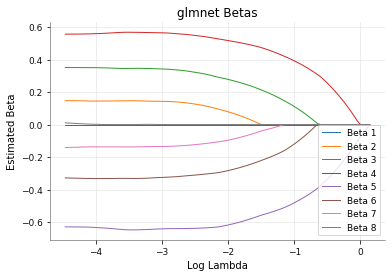

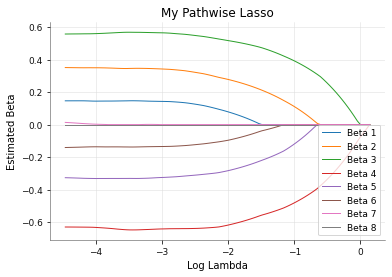

In [10]:
# loaded scaled and recovered betas here:
rLasso_pw_betas = np.array(pd.read_csv('./data/rlassobeta_unscaled.csv'))
rLasso_pw_betas_recovered = np.array(pd.read_csv('./data/rlassobeta_scaled.csv'))

for i in range(8):
    plt.plot(np.log(lambda_all), rLasso_pw_betas[i,:], label=f'Beta {i+1}')
plt.title('glmnet Betas')
plt.xlabel('Log Lambda')
plt.ylabel('Estimated Beta')
plt.legend()
plt.show()

for i in range(8):
    plt.plot(np.log(lambda_all), myLasso_pw_betas[i,:], label=f'Beta {i+1}')
plt.title('My Pathwise Lasso')
plt.xlabel('Log Lambda')
plt.ylabel('Estimated Beta')
plt.legend()
plt.show()

c) [5 pts] Based on your plot, if we decrease $\lambda$ from its maximum value, which two variables enter (start to have nonzero values) the model first? You may denote your covariates as $X_1, ..., X_8$. 

$\beta_4$ and $\beta_3$ start to have non-zero values first. 

d) [5 pts] In Question 1, we calculated the L1 norm discrepancy between our solution and `glmnet` on the first 8 parameters. In this question, we will calculate the discrepancy on **all** coefficients, and over all $\lambda$ parameters. After calculating the discrepancies, show a scatter plot of  **log($\lambda$) vs. discrepancy**. Comment on what you observe.

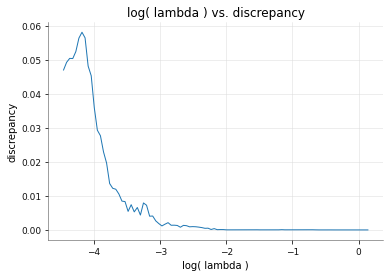

In [11]:
discrepancy = []

for i in range(len(lambda_all)):
    discrepancy.append(np.linalg.norm((rLasso_pw_betas[1:,i] - myLasso_pw_betas[:,i]), ord=1))
discrepancy = np.array(discrepancy)

plt.plot(np.log(lambda_all), discrepancy)
plt.title('log( lambda ) vs. discrepancy')
plt.xlabel('log( lambda )')
plt.ylabel('discrepancy')
plt.show()

We observe first that the overall magnitude in discrepancy is very small (<0.06). We also see that as we increase log(lambda) (decreaseing lambda), the discrepancy decreases and eventually plateaus at 0.

e) [15 pts] Based on the solution you obtained in the previous question, recover the unscaled coefficients using the formula in HW4. Then compare the first 9 coefficients (including the intercept term) with the following using a similar plot in b). Report the maximum value of discrepancy (see d) across all $\lambda$ values.

In [12]:
myLass_pw_recovered = []
for i in range(len(lambda_all)):
    gamas = myLasso_pw_betas[:,i][0:9]
    recovered_betas = []
    recovered_intercept = mean_y - np.sum(mean_X[1:9]*((sd_y*gamas[1:])/sd_X[1:9]))
    recovered_betas.append(recovered_intercept)
    for j in np.arange(1,9):
        recovered_betas.append((sd_y*gamas[j])/sd_X[j])
    myLass_pw_recovered.append(recovered_betas)
myLass_pw_recovered = np.array(myLass_pw_recovered).T

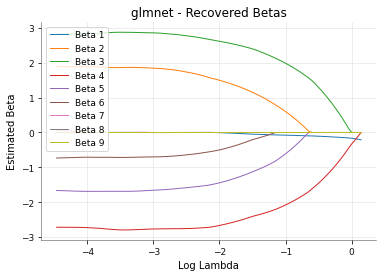

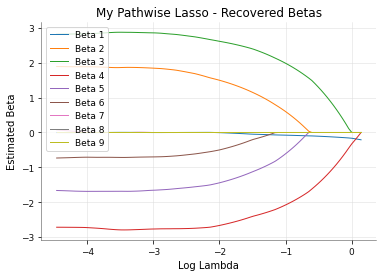

In [13]:
for i in range(9):
    plt.plot(np.log(lambda_all), myLass_pw_recovered[i,:], label=f'Beta {i+1}')

plt.title('glmnet - Recovered Betas')
plt.xlabel('Log Lambda')
plt.ylabel('Estimated Beta')
plt.legend()
plt.show()

for i in range(9):
    plt.plot(np.log(lambda_all), myLass_pw_recovered[i,:], label=f'Beta {i+1}')

plt.title('My Pathwise Lasso - Recovered Betas')
plt.xlabel('Log Lambda')
plt.ylabel('Estimated Beta')
plt.legend()
plt.show()

In [14]:
discrepancy_rec = []
for i in range(len(lambda_all)):
    discrepancy_rec.append(np.linalg.norm((rLasso_pw_betas_recovered[0:9,i] - myLass_pw_recovered[:,i]), ord=1))
discrepancy = np.array(discrepancy)
print(f'Max discrepency {np.max(discrepancy_rec)}')

Max discrepency 10.508252901876533
